In [ ]:
import os
import sys

# Go up one directory level to reach root
root_dir = os.path.dirname(os.getcwd())
os.chdir(root_dir)

# Add root to Python path
sys.path.insert(0, root_dir)

print(f"Current working directory: {os.getcwd()}")
print(f"Root directory added to path: {root_dir}")

In [ ]:
%load_ext autoreload
%autoreload 2
from functions._utils_ import *

In [ ]:
# https://datadryad.org/dataset/doi:10.5061/dryad.cjsxksn3p
PROSTATE_CANCER_DATASET_PATH = os.path.join(
    CURRENT_DIR,
    "test_rawdata",
    "A1-dataset_prostate_cancer",
    "Benign_vs_Cancer.pkl",
)

load_dataset = RamanDataLoader(PROSTATE_CANCER_DATASET_PATH)
rawdata = load_dataset.data

In [ ]:
# create a subset for a given key value
chum_df = rawdata[rawdata['Cohort'] == 'CHUM']
uhn_df = rawdata[rawdata['Cohort'] == 'UHN']
chuq_df = rawdata[rawdata['Cohort'] == 'CHUQc-UL']
print(rawdata.shape, chum_df.shape, uhn_df.shape, chuq_df.shape)

In [ ]:
# hirushu_dir = os.getcwd() + '/test_rawdata/Tamura/引き継ぎ/ヒルシュ'
# hirushu_dir

# normal_dfs = []
# window_size = 50s
# for k in range(1, 4):
#     csv_path = os.path.join(hirushu_dir, 'データ', 'merged_data_raw', f'Case{k}', 'normal', 'normal.csv')
#     loader = RamanDataLoader(csv_path)
#     df = loader.data
#     processor = RamanNoiseProcessor(df)
#     processed_df = processor.baselineAndGaussianNoise(window_size=window_size)
#     normal_dfs.append(processed_df)

In [ ]:
def processDFA1(df: pd.DataFrame) -> Tuple[pd.DataFrame, list]:
    """
    Process the DataFrame to create a new DataFrame with interpolated spectra.
    Args:
        df (pd.DataFrame): Input DataFrame with columns 'xAxis', 'RawSpectra', 'CoreID', and 'Label'.

    Returns:
        pd.DataFrame: New DataFrame with interpolated spectra.
        list: List of labels corresponding to the spectra.
    """
    all_wavenumbers = np.unique(np.concatenate(df["xAxis"].values))
    all_wavenumbers.sort()

    data = {}
    for idx, (wn, spec, cid) in enumerate(zip(
            df["xAxis"],
            df["RawSpectra"],
            df["CoreID"])):
        # Make unique column name if needed
        col_name = f"{cid}_{idx}"
        interp_spec = np.interp(all_wavenumbers, wn, spec)
        data[col_name] = interp_spec

    # 3. Create DataFrame: index=wavenumber, columns=ids
    merged_df = pd.DataFrame(data, index=all_wavenumbers)
    merged_df.index.name = "wavenumber"

    return merged_df

def load_pickle(path):
    if not os.path.exists(path):
        print(f"File not found: {path}")
        return None
    
    data = None
    with open(path, 'rb') as f:
        data = pickle.load(f)
    return data


In [ ]:
region = (600, 1500)  # Raman region of interest
labels = ["benign", "cancer"]
# https://ramanspy.readthedocs.io/en/latest/preprocessing.html
# https://www.nature.com/articles/s41377-024-01394-5
preprocess_steps_test = [
    rp.preprocessing.misc.Cropper(region=region),
    rp.preprocessing.despike.WhitakerHayes(),
    rp.preprocessing.denoise.SavGol(window_length=11, polyorder=3),
    # rp.preprocessing.baseline.ASPLS(),
    rp.preprocessing.baseline.ModPoly(tol=0.001),
    # rp.preprocessing.normalise.Vector(),
    SNV()   # Use SNV normalization as in the Readme
]

In [ ]:
chumDF_benign = load_pickle(os.path.join(
    CURRENT_DIR,
    "data",
    "preprocessed_data",
    "chum_benign.pkl"
))

if chumDF_benign is None:
    chumDF_benign = RamanPipeline().preprocess(
        dfs=[processDFA1(chum_df[chum_df['Label'] == 'Benign'])],
        label=labels[0],
        region=region,
        preprocessing_steps=preprocess_steps_test,
        visualize_steps=False,
        save_pkl=True,
        save_pkl_name="chum_benign"
    )

chumDF_cancer = load_pickle(os.path.join(
    CURRENT_DIR,
    "data",
    "preprocessed_data",
    "chum_cancer.pkl"
))

if chumDF_cancer is None:
    chumDF_cancer = RamanPipeline().preprocess(
        dfs=[processDFA1(chum_df[chum_df['Label'] == 'Cancer'])],
        label=labels[1],
        region=region,
        preprocessing_steps=preprocess_steps_test,
        visualize_steps=False,
        save_pkl=True,
        save_pkl_name="chum_cancer"
    )

In [ ]:
uhnDF_benign = load_pickle(os.path.join(
    CURRENT_DIR,
    "data",
    "preprocessed_data",
    "uhn_benign.pkl"
))

if uhnDF_benign is None:
    uhnDF_benign = RamanPipeline().preprocess(
        dfs=[processDFA1(uhn_df[uhn_df['Label'] == 'Benign'])],
        label=labels[0],
        region=region,
        preprocessing_steps=preprocess_steps_test,
        visualize_steps=False,
        save_pkl=True,
        save_pkl_name="uhn_benign"
    )

uhnDF_cancer = load_pickle(os.path.join(
    CURRENT_DIR,
    "data",
    "preprocessed_data",
    "uhn_cancer.pkl"
))

if uhnDF_cancer is None:
    uhnDF_cancer = RamanPipeline().preprocess(
        dfs=[processDFA1(uhn_df[uhn_df['Label'] == 'Cancer'])],
        label=labels[1],
        region=region,
        preprocessing_steps=preprocess_steps_test,
        visualize_steps=False,
        save_pkl=True,
        save_pkl_name="uhn_cancer"
    )

In [ ]:
chuqDF_benign = load_pickle(os.path.join(
    CURRENT_DIR,
    "data",
    "preprocessed_data",
    "chuq_benign.pkl"
))

if chuqDF_benign is None:
    chuqDF_benign = RamanPipeline().preprocess(
        dfs=[processDFA1(chuq_df[chuq_df['Label'] == 'Benign'])],
        label=labels[0],
        region=region,
        preprocessing_steps=preprocess_steps_test,
        visualize_steps=False,
        save_pkl=True,
        save_pkl_name="chuq_benign"
    )

chuqDF_cancer = load_pickle(os.path.join(
    CURRENT_DIR,
    "data",
    "preprocessed_data",
    "chuq_cancer.pkl"
))

if chuqDF_cancer is None:
    chuqDF_cancer = RamanPipeline().preprocess(
        dfs=[processDFA1(chuq_df[chuq_df['Label'] == 'Cancer'])],
        label=labels[1],
        region=region,
        preprocessing_steps=preprocess_steps_test,
        visualize_steps=False,
        save_pkl=True,
        save_pkl_name="chuq_cancer"
    )

In [ ]:
cancer_spectra = [uhnDF_cancer, chuqDF_cancer]
benign_spectra = [chuqDF_benign, uhnDF_benign]
test_spectra = [k["processed"] for k in cancer_spectra + benign_spectra]
true_labels = []
for k in cancer_spectra + benign_spectra:
    true_labels.extend(k["labels"])

In [32]:
ramanML = RamanML()

In [33]:
# kernel = "linear"
# MODEL_SHORT = f"SVC-{kernel.upper()}"
# mlresult = ramanML.train_svc(normal_data=([chumDF_benign["processed"]], labels[0]),
#                              disease_data=([chumDF_cancer["processed"]], labels[1]), param_search=False, test_size=0.2,
#                              SVC_model=ramanML.SVCMODEL(kernel=kernel, C=1.0, gamma='scale', class_weight='balanced', probability=True),)

MODEL_SHORT = "RF"
mlresult = ramanML.train_rf(normal_data=([chumDF_benign["processed"]], labels[0]),
                            disease_data=([chumDF_cancer["processed"]], labels[1]), param_search=False, test_size=0.2,
                            RF_model=ramanML.RFMODEL(n_estimators=200,           # More trees for stability
                                                     criterion="gini",           # Or "entropy" for information gain
                                                     # Let trees grow deep (or set to 10-30 to reduce overfitting)
                                                     max_depth=None,
                                                     min_samples_split=5,
                                                     min_samples_leaf=10,
                                                     max_features="sqrt",        # Good default for classification
                                                     class_weight="balanced_subsample",    # Important for imbalanced classes
                                                     random_state=42,            # For reproducibility
                                                     n_jobs=-1,                  # Use all CPU cores
                                                     bootstrap=True,             # Default
                                                     oob_score=True,),)


pprint(translate_confusion_matrix(
    mlresult["confusion_matrix"], labels), indent=2)
pprint(mlresult["classification_report"], indent=2)
print(
    f"CV Accuracy: {mlresult['cross_val_score'].mean():.3f} ± {mlresult['cross_val_score'].std():.3f}")
# print(f"Decision Function Score: {mlresult['decision_function_score'].mean():.3f} ± {mlresult['decision_function_score'].std():.3f}")

Interpolated (396) benign and (1088) cancer spectra to common axis.
Training Random Forest with 1187 training samples and 297 test samples.
{ 'benign': {'benign': 44, 'cancer': 35},
  'cancer': {'benign': 15, 'cancer': 203}}
('              precision    recall  f1-score   support\n'
 '\n'
 '      benign       0.75      0.56      0.64        79\n'
 '      cancer       0.85      0.93      0.89       218\n'
 '\n'
 '    accuracy                           0.83       297\n'
 '   macro avg       0.80      0.74      0.76       297\n'
 'weighted avg       0.82      0.83      0.82       297\n')
CV Accuracy: 0.847 ± 0.024


In [34]:
# predict_data = ramanML.predict(
#     test_spectra=test_spectra,
#     # model = mlresult["model"]
# )

predict_data = ramanML.predict_with_threshold(
    test_spectra=test_spectra,
    positive_label=labels[1],
    # model = mlresult["model"],
    threshold=0.62,
)

pprint(predict_data["label_percentages"], indent=2)
pprint(predict_data["most_common_label"])

{np.str_('benign'): 0.3029970760233918, 'cancer': 0.6970029239766082}
'cancer'


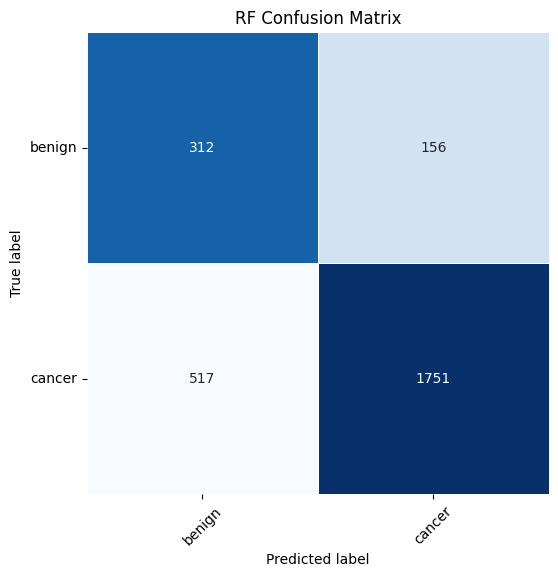

Predict Accuracy:
benign: 66.67%
cancer: 77.20%


In [35]:
visualizer = RamanVisualizer(ramanML=ramanML)
predict_accuracy, plotdata = visualizer.confusion_matrix_heatmap(
    y_true=true_labels,          # true labels for test set
    y_pred=predict_data["y_pred"],  # predicted labels for test set
    # class names, e.g. ["benign", "cancer"]
    class_labels=labels,
    title=f"{MODEL_SHORT} Confusion Matrix",
    normalize=False,
    cmap="Blues",
    figsize=(8, 6),
    fmt="d",
)
print("Predict Accuracy:")
print("=====================================")
for i, (label, percentage) in enumerate(predict_accuracy.items()):
    print(f"{label}: {percentage:.2f}%")

In [ ]:
get_shap = visualizer.shap_explain(reduce_features=False,  # Disable feature reduction to avoid dimension mismatch         # Enable fast mode for speed
                                nsamples=30,            # Reduce samples for faster computation
                                max_background_samples=30,
                                max_test_samples=15,
                                show_plots=True)

Inspecting 1 random spectra...

Analyzing spectrum 1/1...
Predicting 1 test samples with 21897 features.
Using stored data: 1187 background samples, 1 test samples
Background data reduced to 30 samples
Computing SHAP values for 1 samples with 30 background samples...
Using TreeExplainer for RandomForest model...
Debug - Final types: expected_val=<class 'float'> (value: 0.5000000000000003)
Debug - sample_shap type: <class 'numpy.ndarray'>, shape: (21897,)
Debug - test_sample type: <class 'numpy.ndarray'>, shape: (21897,)
Debug: class_shap_values shape for benign: (21897,)
Debug: class_shap_values type: <class 'numpy.ndarray'>
Debug: class_shap_values shape for cancer: (21897,)
Debug: class_shap_values type: <class 'numpy.ndarray'>


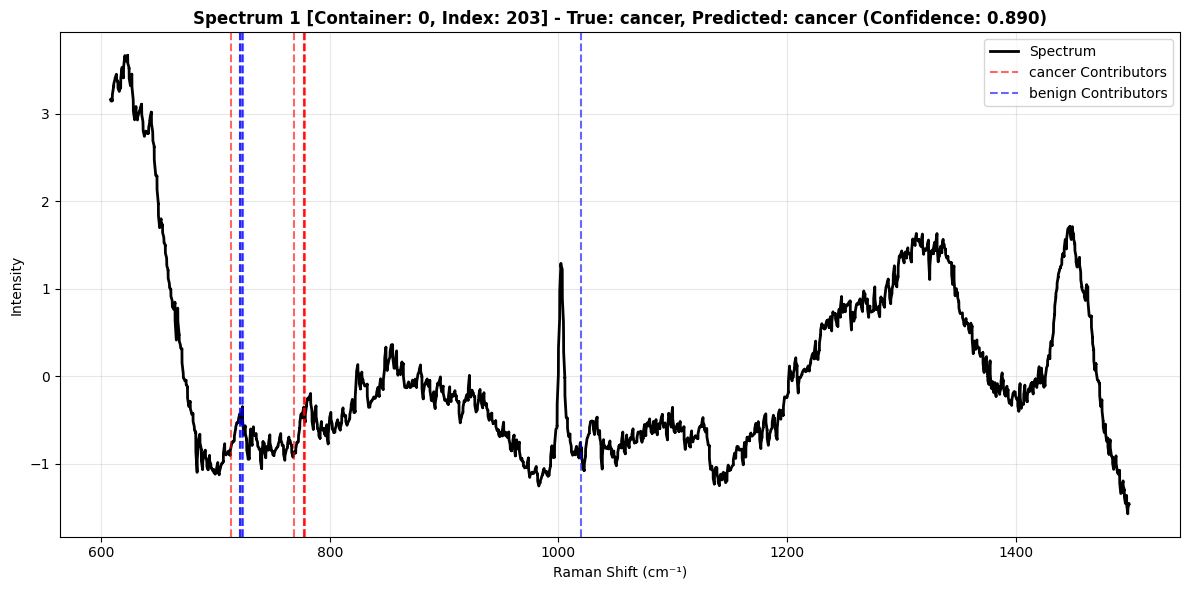

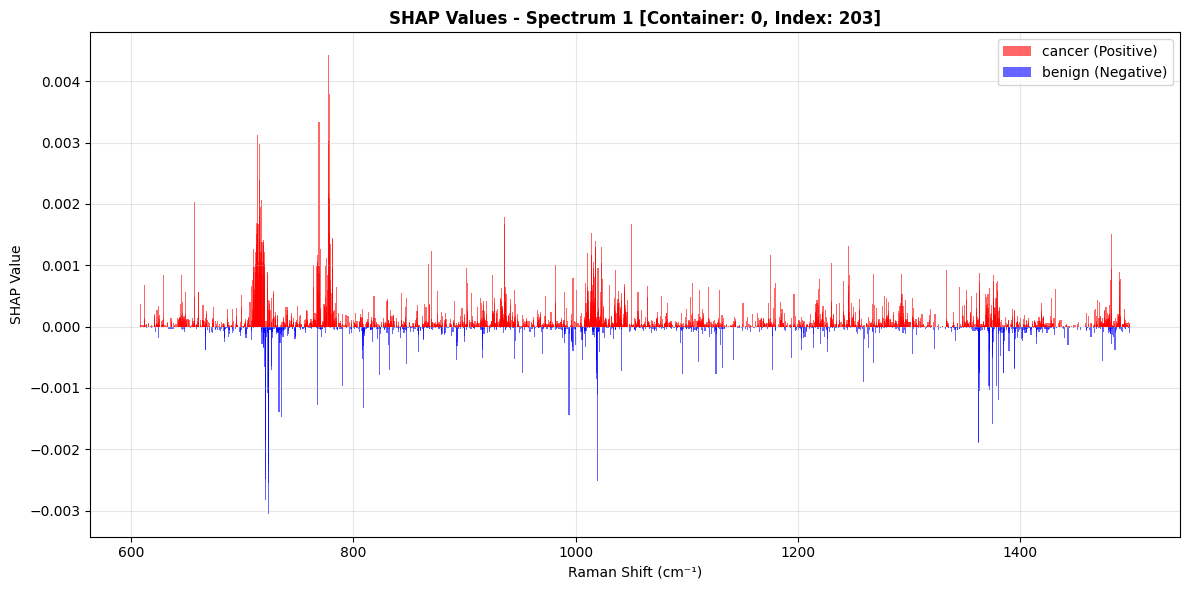

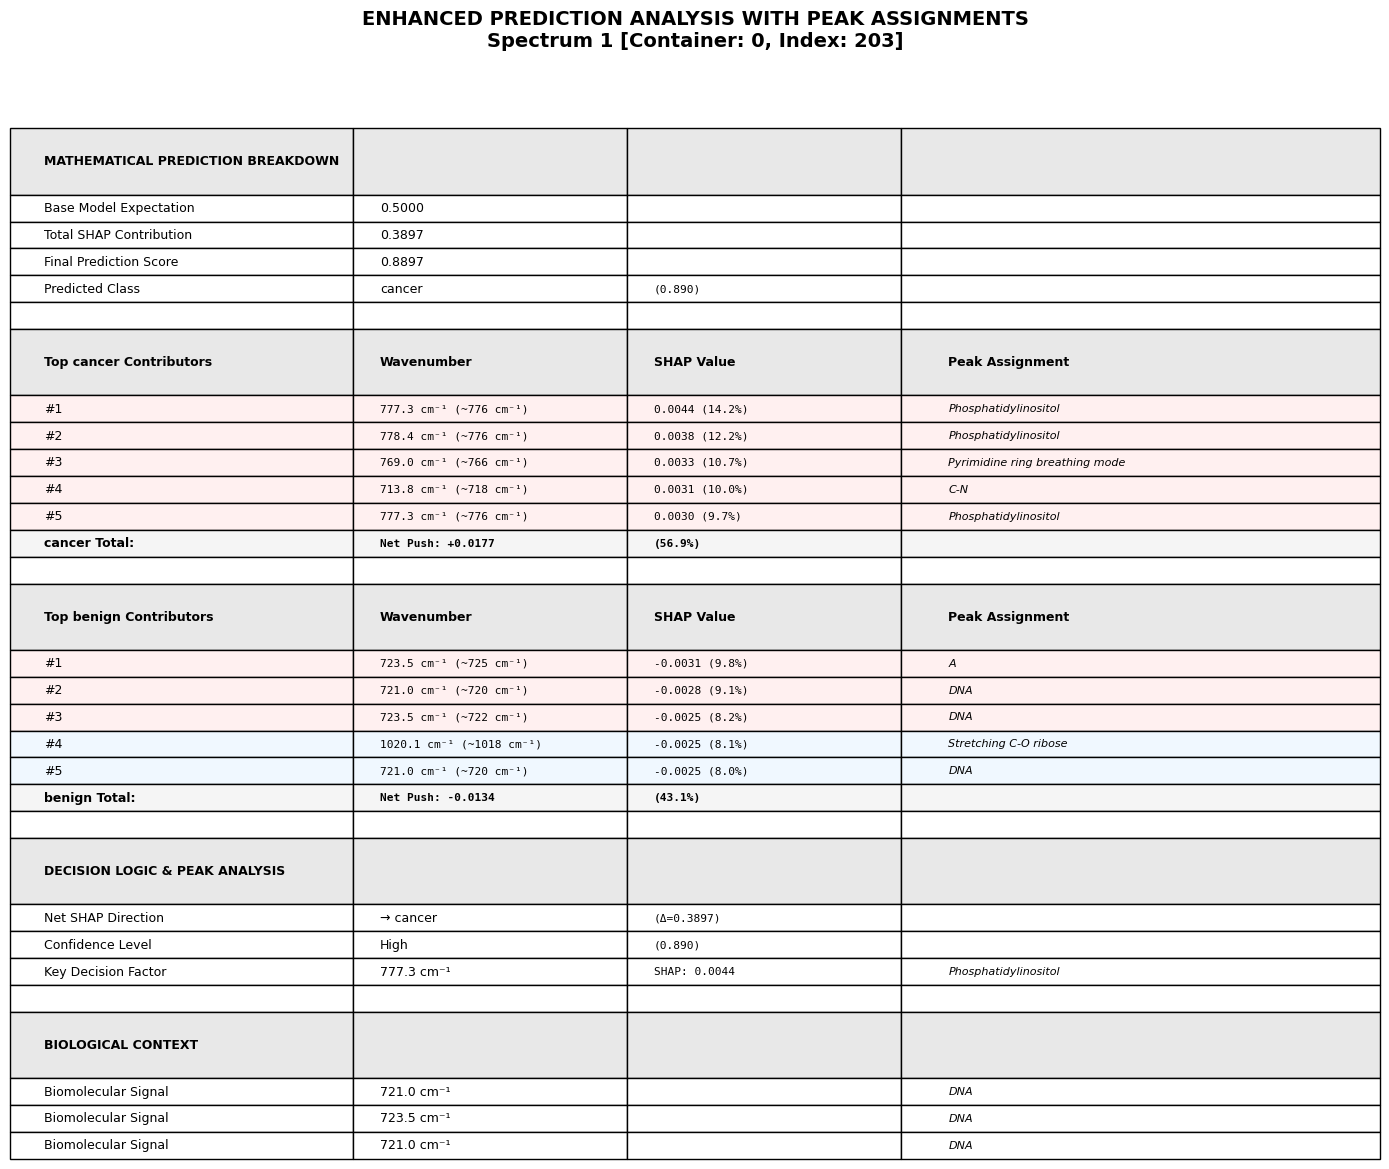

Spectrum 1 Summary [Container: 0, Index: 203]:
  True Label: cancer
  Predicted: cancer (Confidence: 0.890)
  Correct: Yes
  Top cancer contributor: 777.3 cm⁻¹ (SHAP: 0.0044)
  Top benign contributor: 723.5 cm⁻¹ (SHAP: -0.0031)


In [36]:
shap_random_spectra = visualizer.inspect_random_spectra(test_spectra=test_spectra,
                                                        true_labels=true_labels,
                                                        n_samples=1,
                                                        positive_label=labels[1],
                                                        negative_label=labels[0],
                                                )

In [ ]:
# RamanVisualizer(None).pca2d(
#     spectral_data=mlresult["x_train"],
#     spectral_axis=np.arange(mlresult["x_train"].shape[1]),  # PCA does not use axis, just needs shape
#     title="PCA of SVC Training Data",
#     sample_names=mlresult["y_train"],
#     sample_limit=50  # adjust as needed
# )

In [ ]:
# save_to_onnx = MLModel()
# save_to_onnx.save(
#     model=mlresult["model"],
#     labels=labels,
#     filename=f"{MODEL_SHORT}_raman_prostate_model",
#     common_axis=ramanML.common_axis,
#     n_features_in=ramanML.n_features_in,
#     meta={
#         "model_type": mlresult["model"].__class__.__name__,
#         "model_name": f"{MODEL_SHORT} raman prostate",
#         "model_version": "2.0",
#         "model_description": f"{mlresult['model'].__class__.__name__} model for prostate cancer classification based on Raman spectroscopy data",
#         "model_author": "MUHAMMAD HELMI BIN ROZAIN",
#     },
#     other_meta={
#         "dataset": {"url": "https://datadryad.org/dataset/doi:10.5061/dryad.cjsxksn3p",
#                     "description": "Prostate cancer dataset from Dryad"},
#         "predict_accuracy": predict_accuracy,
#         "cross_val_score": {
#             "std": mlresult["cross_val_score"].std(),
#             "mean": mlresult["cross_val_score"].mean(),
#         },
#         "classification_report": mlresult["classification_report"],
#         "training_time": mlresult["training_time"],
#     }

# )

In [ ]:
# MODEL_SHORTS = ["SVC-LINEAR", "RF"]
# for mshort in MODEL_SHORTS:
#     ramanML = RamanML()
#     if mshort == "SVC-LINEAR":
#         mlresult = ramanML.train_svc(normal_data=([chumDF_benign["processed"]], labels[0]),
#                                      disease_data=([chumDF_cancer["processed"]], labels[1]), param_search=False, test_size=0.2,
#                                      SVC_model=ramanML.SVCMODEL(kernel='linear', C=1.0, gamma='scale', class_weight='balanced'),)
#     else:
#         mlresult = ramanML.train_rf(normal_data=([chumDF_benign["processed"]], labels[0]),
#                                     disease_data=([chumDF_cancer["processed"]], labels[1]), param_search=False, test_size=0.2,
#                                     RF_model=ramanML.RFMODEL(n_estimators=200,           # More trees for stability
#                                                              criterion="gini",           # Or "entropy" for information gain
#                                                              # Let trees grow deep (or set to 10-30 to reduce overfitting)
#                                                              max_depth=None,
#                                                              min_samples_split=2,        # Default, can increase to reduce overfitting
#                                                              min_samples_leaf=1,         # Default, can increase to reduce overfitting
#                                                              max_features="log2",        # Good default for classification
#                                                              class_weight="balanced",    # Important for imbalanced classes
#                                                              random_state=42,            # For reproducibility
#                                                              n_jobs=-1,                  # Use all CPU cores
#                                                              bootstrap=True,             # Default
#                                                              oob_score=True,),)

#     predict_data = ramanML.predict(
#         test_spectra=test_spectra,
#         # model = mlresult["model"]
#     )

#     predict_accuracy, plotdata = RamanVisualizer(None).confusion_matrix_heatmap(
#         y_true=true_labels,          # true labels for test set
#         y_pred=predict_data["y_pred"],  # predicted labels for test set
#         # class names, e.g. ["benign", "cancer"]
#         class_labels=labels,
#         title="SVC Confusion Matrix",
#         normalize=False,
#         cmap="Blues",
#         figsize=(8, 6),
#         fmt="s",
#         show_heatmap=False,
#     )

#     save_to_onnx = MLModel()
#     save_to_onnx.save(
#         model=mlresult["model"],
#         labels=labels,
#         filename=f"{mshort}_raman_prostate_model",
#         common_axis=ramanML.common_axis,
#         n_features_in=ramanML.n_features_in,
#         meta={
#             "model_type": mlresult["model"].__class__.__name__,
#             "model_name": f"{mshort} raman prostate",
#             "model_version": "1.0",
#             "model_description": "SVC model for prostate cancer classification based on Raman spectroscopy data",
#             "model_author": "MUHAMMAD HELMI BIN ROZAIN",
#         },
#         other_meta={
#             "dataset": {"url": "https://datadryad.org/dataset/doi:10.5061/dryad.cjsxksn3p",
#                         "description": "Prostate cancer dataset from Dryad"},
#             "predict_accuracy": predict_accuracy,
#             "cross_val_score": {
#                 "std": mlresult["cross_val_score"].std(),
#                 "mean": mlresult["cross_val_score"].mean(),
#             },
#             "classification_report": mlresult["classification_report"],
#         }

#     )